In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "NF-YA"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn003161,MRQTKRKVNSRKGKQKQNRRQQFLLATENKAQIAQKRFAPEISLQD...,245,1
1,Achn029561,MPTKSKTEDQQAENGAHIIPPSAVYAQPWWRGIGNNAMSSPVGHIN...,317,1
2,Achn050401,MQDLCKKDSELSSTSTHSMTPRVTGGAPWLTSTALQIESTLSKSLS...,539,1
3,Achn059051,MTMHTVYLKEHDGIVQNPTSQLPPAAVPWWSGHGSQSAHTESFGQF...,699,1
4,Achn115261,MATPNQHDHNLKQMGFRFQDQDSSSTQSTGQSHHEVASIGESDPYG...,263,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1794,0.003344,0.000000,0.000000,0.010033,0.0,0.010033,0.000000,0.003344,0.006689,0.000000,...,0.000000,0.003344,0.000000,0.000000,0.000000,0.0,0.003344,0.000000,0.0,0.000000
3906,0.010309,0.000000,0.000000,0.000000,0.0,0.010309,0.000000,0.000000,0.010309,0.051546,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
453,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.006173,0.000000,0.012346,0.000000,...,0.000000,0.000000,0.006173,0.000000,0.000000,0.0,0.006173,0.000000,0.0,0.000000
1140,0.003846,0.003846,0.003846,0.007692,0.0,0.000000,0.003846,0.003846,0.011538,0.007692,...,0.003846,0.000000,0.003846,0.000000,0.000000,0.0,0.003846,0.000000,0.0,0.003846
4140,0.000000,0.000000,0.002967,0.000000,0.0,0.005935,0.000000,0.002967,0.002967,0.002967,...,0.002967,0.005935,0.002967,0.005935,0.002967,0.0,0.000000,0.002967,0.0,0.000000


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3915, 441)
X_test: (979, 441)
y_train: (3915,)
y_test: (979,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 30s 632ms/step - accuracy: 0.4062 - loss: 0.6933

28/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7493 - loss: 0.6820   

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8119 - loss: 0.6419 - val_accuracy: 0.9872 - val_loss: 0.1039


Epoch 2/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0763

29/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9912 - loss: 0.0693 

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9892 - loss: 0.0663 - val_accuracy: 0.9821 - val_loss: 0.0509


Epoch 3/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9531 - loss: 0.0612

26/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9874 - loss: 0.0329 

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9884 - loss: 0.0351 - val_accuracy: 0.9923 - val_loss: 0.0333


Epoch 4/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0590

26/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.0433 

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9901 - loss: 0.0392 - val_accuracy: 0.9949 - val_loss: 0.0291


Epoch 5/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0127

26/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9883 - loss: 0.0454 

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9899 - loss: 0.0393 - val_accuracy: 0.9936 - val_loss: 0.0315


Epoch 6/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0073

27/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0154 

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0161 - val_accuracy: 0.9770 - val_loss: 0.0579


Epoch 7/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9531 - loss: 0.2061

26/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9879 - loss: 0.0471 

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9912 - loss: 0.0338 - val_accuracy: 0.9898 - val_loss: 0.0300


Epoch 8/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0067

27/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0179 

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0181 - val_accuracy: 0.9936 - val_loss: 0.0294


Epoch 9/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0119

26/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0093 

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0126 - val_accuracy: 0.9770 - val_loss: 0.0727


Epoch 10/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0202

26/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0196 

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0188 - val_accuracy: 0.9872 - val_loss: 0.0342


Epoch 11/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0015

27/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0075 

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0099 - val_accuracy: 0.9681 - val_loss: 0.0979


Epoch 12/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0339

26/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0172 

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0158 - val_accuracy: 0.9860 - val_loss: 0.0546


Epoch 13/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0042

27/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0095 

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0110 - val_accuracy: 0.9860 - val_loss: 0.0462


Epoch 14/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0026

26/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0062 

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0070 - val_accuracy: 0.9885 - val_loss: 0.0427



[Train Accuracy: 99.81% - Test Accuracy: 98.47%]


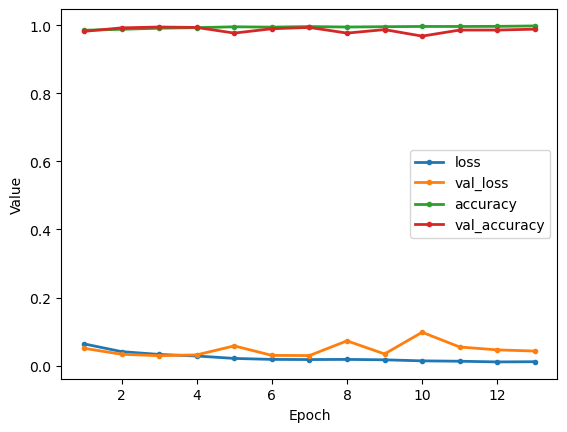

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
1794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3915, 8707)
X_test: (979, 8707)
y_train: (3915,)
y_test: (979,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,229,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,272,513 (8.67 MB)

 Trainable params: 2,272,513 (8.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 30s 639ms/step - accuracy: 0.4844 - loss: 0.6932

 8/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4821 - loss: 0.6928   

15/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5105 - loss: 0.6909

22/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5614 - loss: 0.6870

29/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6056 - loss: 0.6805

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6423 - loss: 0.6695

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6729 - loss: 0.6539

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6984 - loss: 0.6348 - val_accuracy: 0.9847 - val_loss: 0.1037


Epoch 2/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0749

 8/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9916 - loss: 0.0731 

15/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9920 - loss: 0.0622

22/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9922 - loss: 0.0553

29/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9924 - loss: 0.0510

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9925 - loss: 0.0475

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9927 - loss: 0.0446

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9929 - loss: 0.0422 - val_accuracy: 0.9911 - val_loss: 0.0397


Epoch 3/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0050

 8/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9961 - loss: 0.0097 

15/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9967 - loss: 0.0088

22/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9972 - loss: 0.0081

29/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9976 - loss: 0.0074

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9979 - loss: 0.0069

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9980 - loss: 0.0065

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9981 - loss: 0.0063 - val_accuracy: 0.9911 - val_loss: 0.0399


Epoch 4/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0033

 8/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0028 

15/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0022

22/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0021

29/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0020

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0020

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0020

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9996 - loss: 0.0019 - val_accuracy: 0.9911 - val_loss: 0.0492


Epoch 5/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 8.6227e-04

 8/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0010     

15/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0018

22/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0020

29/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0021

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0022

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.0022

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9992 - loss: 0.0022 - val_accuracy: 0.9911 - val_loss: 0.0649


Epoch 6/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 3.2191e-04

 8/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.1681e-04 

15/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.0875e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3077e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5606e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6541e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.7163e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.7407e-04 - val_accuracy: 0.9911 - val_loss: 0.0617


Epoch 7/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.7132e-04

 8/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7782e-04 

15/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5694e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.3921e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2551e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1715e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0936e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 2.0215e-04 - val_accuracy: 0.9911 - val_loss: 0.0763


Epoch 8/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 8.4309e-05

 8/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0894e-04 

15/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.8800e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9476e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9359e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.9984e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.0191e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 2.0303e-04 - val_accuracy: 0.9911 - val_loss: 0.0655


Epoch 9/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 1.0000 - loss: 5.1974e-05

 8/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.7079e-05 

15/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.9699e-05

22/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.5905e-05

30/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.8939e-05

37/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.0188e-05

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.5327e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 8.8982e-05 - val_accuracy: 0.9911 - val_loss: 0.0711


Epoch 10/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 8.4504e-05

 8/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.9986e-05 

14/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.1202e-05

21/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.2705e-05

28/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.5613e-05

35/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.9319e-05

41/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.0296e-05

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.0807e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 8.0778e-05 - val_accuracy: 0.9911 - val_loss: 0.0818


Epoch 11/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.9718e-05

 8/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4125e-04 

15/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4231e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3010e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2119e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1464e-04

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1086e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0715e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.0666e-04 - val_accuracy: 0.9911 - val_loss: 0.0795


Epoch 12/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 3.7130e-05

 8/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.7752e-05 

15/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.3129e-05

23/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.1728e-05

30/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.0665e-05

37/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.0000e-05

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.9264e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.8568e-05 - val_accuracy: 0.9911 - val_loss: 0.0840



[Train Accuracy: 100.00% - Test Accuracy: 99.18%]


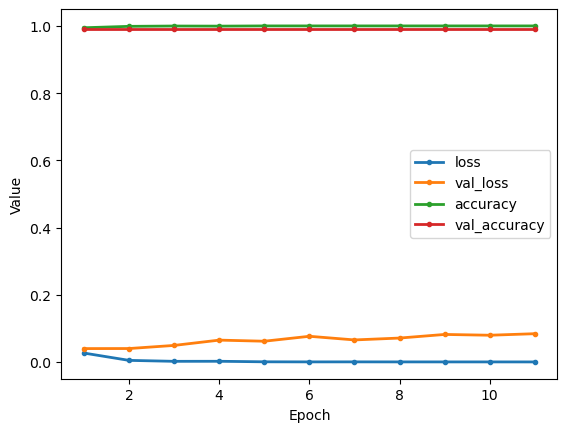

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
1794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      35,515,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,556,609 (135.64 MB)

 Trainable params: 35,556,609 (135.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 41s 859ms/step - accuracy: 0.4688 - loss: 0.6931

 2/49 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.4844 - loss: 0.6931 

 3/49 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.4844 - loss: 0.6931

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.4814 - loss: 0.6931

 5/49 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.4852 - loss: 0.6930

 6/49 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.4972 - loss: 0.6929

 7/49 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.5094 - loss: 0.6928

 8/49 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.5204 - loss: 0.6927

 9/49 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.5316 - loss: 0.6926

10/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.5436 - loss: 0.6925

11/49 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.5527 - loss: 0.6923

12/49 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.5597 - loss: 0.6922

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.5647 - loss: 0.6920

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.5686 - loss: 0.6918

15/49 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.5715 - loss: 0.6915

16/49 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.5741 - loss: 0.6913

17/49 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.5768 - loss: 0.6910

18/49 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.5797 - loss: 0.6907

19/49 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 0.5829 - loss: 0.6903

20/49 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.5860 - loss: 0.6899

21/49 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 0.5893 - loss: 0.6895

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.5930 - loss: 0.6891

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.5970 - loss: 0.6886

24/49 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.6010 - loss: 0.6880

25/49 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.6052 - loss: 0.6874

26/49 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.6093 - loss: 0.6868

27/49 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.6135 - loss: 0.6861

28/49 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.6177 - loss: 0.6854

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.6220 - loss: 0.6846

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.6262 - loss: 0.6838

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.6305 - loss: 0.6829

32/49 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.6347 - loss: 0.6820

33/49 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.6388 - loss: 0.6810

34/49 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.6429 - loss: 0.6800

35/49 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.6470 - loss: 0.6789

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.6510 - loss: 0.6777

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.6549 - loss: 0.6764

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.6587 - loss: 0.6751

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.6624 - loss: 0.6737

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 0.6661 - loss: 0.6723

41/49 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.6698 - loss: 0.6707

42/49 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.6733 - loss: 0.6691

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6768 - loss: 0.6675

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6802 - loss: 0.6657

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6836 - loss: 0.6639

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6869 - loss: 0.6620

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6901 - loss: 0.6601

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6932 - loss: 0.6581

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6963 - loss: 0.6560

49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.6993 - loss: 0.6541 - val_accuracy: 0.9923 - val_loss: 0.2035


Epoch 2/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - accuracy: 1.0000 - loss: 0.2191

 2/49 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.9961 - loss: 0.2155

 3/49 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9957 - loss: 0.2132

 4/49 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9958 - loss: 0.2117

 5/49 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9960 - loss: 0.2078

 6/49 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 0.9962 - loss: 0.2029

 7/49 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.9964 - loss: 0.1984

 8/49 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.9966 - loss: 0.1943

 9/49 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.9968 - loss: 0.1898

10/49 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9970 - loss: 0.1854

11/49 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 0.9971 - loss: 0.1812

12/49 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9973 - loss: 0.1771

13/49 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9974 - loss: 0.1731

14/49 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9974 - loss: 0.1695

15/49 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9974 - loss: 0.1660

16/49 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9975 - loss: 0.1626

17/49 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9975 - loss: 0.1594

18/49 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9974 - loss: 0.1564

19/49 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9974 - loss: 0.1535

20/49 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9974 - loss: 0.1506

21/49 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9973 - loss: 0.1479

22/49 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9973 - loss: 0.1453

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9973 - loss: 0.1428

24/49 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9972 - loss: 0.1404

25/49 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9972 - loss: 0.1381

26/49 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9972 - loss: 0.1358

27/49 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9972 - loss: 0.1337

28/49 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 0.9971 - loss: 0.1317

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.9971 - loss: 0.1298

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.9970 - loss: 0.1280

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.9970 - loss: 0.1262

32/49 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9970 - loss: 0.1245

33/49 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.9970 - loss: 0.1228

34/49 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.9969 - loss: 0.1212

35/49 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.9969 - loss: 0.1197

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9969 - loss: 0.1182

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9969 - loss: 0.1167

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9969 - loss: 0.1153

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9969 - loss: 0.1139

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9969 - loss: 0.1125

41/49 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9968 - loss: 0.1112

42/49 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9968 - loss: 0.1099

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9968 - loss: 0.1087

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9968 - loss: 0.1075

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9968 - loss: 0.1063

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9968 - loss: 0.1051

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9968 - loss: 0.1040

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9968 - loss: 0.1029

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9968 - loss: 0.1019

49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.9968 - loss: 0.1009 - val_accuracy: 0.9936 - val_loss: 0.0189


Epoch 3/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 1.0000 - loss: 0.0053

 2/49 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 0.0059

 3/49 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - accuracy: 1.0000 - loss: 0.0060

 4/49 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 1.0000 - loss: 0.0059

 5/49 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 1.0000 - loss: 0.0058

 6/49 ━━━━━━━━━━━━━━━━━━━━ 7s 181ms/step - accuracy: 1.0000 - loss: 0.0058

 7/49 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 1.0000 - loss: 0.0058

 8/49 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.9998 - loss: 0.0060

 9/49 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.9996 - loss: 0.0062

10/49 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.9995 - loss: 0.0063

11/49 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.9994 - loss: 0.0063

12/49 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - accuracy: 0.9993 - loss: 0.0063

13/49 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.9993 - loss: 0.0063

14/49 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 0.9993 - loss: 0.0063

15/49 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9992 - loss: 0.0062

16/49 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9992 - loss: 0.0062

17/49 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9992 - loss: 0.0061

18/49 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9992 - loss: 0.0061

19/49 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 0.9992 - loss: 0.0060

20/49 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9992 - loss: 0.0060

21/49 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9992 - loss: 0.0059

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9992 - loss: 0.0059

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.9992 - loss: 0.0058

24/49 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.9992 - loss: 0.0058

25/49 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.9992 - loss: 0.0057

26/49 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.9992 - loss: 0.0056

27/49 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.9992 - loss: 0.0056

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9993 - loss: 0.0055

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9993 - loss: 0.0055

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9993 - loss: 0.0054

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.9993 - loss: 0.0054

32/49 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9993 - loss: 0.0054

33/49 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9993 - loss: 0.0054

34/49 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.9993 - loss: 0.0054

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9993 - loss: 0.0054

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9992 - loss: 0.0054

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9992 - loss: 0.0054

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9992 - loss: 0.0054

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9992 - loss: 0.0054

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9992 - loss: 0.0054

41/49 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9992 - loss: 0.0054

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9992 - loss: 0.0054

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9992 - loss: 0.0054

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9992 - loss: 0.0054

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9992 - loss: 0.0054

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9992 - loss: 0.0054

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9992 - loss: 0.0053

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9992 - loss: 0.0053

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9992 - loss: 0.0053

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.9992 - loss: 0.0053 - val_accuracy: 0.9936 - val_loss: 0.0196


Epoch 4/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 8s 167ms/step - accuracy: 1.0000 - loss: 0.0018

 2/49 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 0.0016

 3/49 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 0.0016

 4/49 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 0.0017

 5/49 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 0.0017

 6/49 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 0.0017

 7/49 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 0.0017

 8/49 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 0.0017

 9/49 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 0.0017

10/49 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 0.0017

11/49 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 0.0017

12/49 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 0.0017

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 0.0017

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 0.0017

15/49 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 0.0017

16/49 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 0.0016

17/49 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 0.0016

18/49 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 0.0016

19/49 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 0.0016

20/49 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 0.0016

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 0.0016

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 0.0016

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 0.0016

24/49 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 0.0016

25/49 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 0.0015

26/49 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 0.0015

27/49 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 0.0015

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 0.0015

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 0.0015

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 0.0015

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 0.0015

32/49 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 0.0015

33/49 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 0.0015

34/49 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 0.0015

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 0.0015

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 0.0015

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 0.0015

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 0.0015

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 0.0015

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 0.0015

41/49 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 0.0015

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 0.0015

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 0.0015

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 0.0015

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 0.0015

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 0.0015

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 0.0015

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 0.0015

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 1.0000 - loss: 0.0015

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.9936 - val_loss: 0.0218


Epoch 5/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 5.0194e-04

 2/49 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 7.1753e-04

 3/49 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 8.2684e-04

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 8.3987e-04

 5/49 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 8.4915e-04

 6/49 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 8.4455e-04

 7/49 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 8.3250e-04

 8/49 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 8.1948e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 8.0460e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 7.8763e-04

11/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 7.7255e-04

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 7.5829e-04

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 7.4553e-04

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 7.3410e-04

15/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 7.2472e-04

16/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 7.1509e-04

17/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 7.0875e-04

18/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 7.0295e-04

19/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 6.9736e-04

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 6.9190e-04

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 6.8653e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 6.8190e-04

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 6.7755e-04

24/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 6.7452e-04

25/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 6.7145e-04

26/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 6.6879e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 6.6591e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 6.6275e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 6.5948e-04

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 6.5620e-04

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 6.5312e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 6.5011e-04

33/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 6.4701e-04

34/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 6.4402e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 6.4109e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 6.3816e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 6.3723e-04

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 6.3628e-04

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 6.3524e-04

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 6.3422e-04

41/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 6.3360e-04

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 6.3287e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 6.3237e-04

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 6.3177e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 6.3116e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 6.3054e-04

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 6.2979e-04

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 6.2903e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 6.2829e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 6.2759e-04 - val_accuracy: 0.9936 - val_loss: 0.0246


Epoch 6/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 1.0000 - loss: 2.0844e-04

 2/49 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 2.3331e-04

 3/49 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 2.7529e-04

 4/49 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 2.8664e-04

 5/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 3.1217e-04

 6/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 3.2662e-04

 7/49 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 3.3401e-04

 8/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 3.3793e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 3.4484e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 3.5076e-04

11/49 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 3.5535e-04

12/49 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 3.5904e-04

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 3.6377e-04

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 3.6663e-04

15/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 3.6838e-04

16/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 3.7057e-04

17/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 3.7232e-04

18/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 3.7391e-04

19/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 3.8625e-04

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 3.9629e-04

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 4.0510e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 4.1248e-04

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 4.1943e-04

24/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 4.2533e-04

25/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 4.3030e-04

26/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 4.3663e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 4.4221e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 4.4711e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 4.5150e-04

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 4.5541e-04

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 4.5865e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 4.6153e-04

33/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 4.6392e-04

34/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 4.6610e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 4.6791e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 4.6954e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 4.7121e-04

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 4.7260e-04

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 4.7374e-04

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 4.7464e-04

41/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 4.7540e-04

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 4.7595e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 4.7638e-04

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 4.7663e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 4.7676e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 4.7672e-04

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 4.7655e-04

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 4.7633e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 1.0000 - loss: 4.7602e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 4.7572e-04 - val_accuracy: 0.9936 - val_loss: 0.0286


Epoch 7/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 1.0000 - loss: 1.5987e-04

 2/49 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 1.6127e-04

 3/49 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 1.5503e-04

 4/49 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 1.4790e-04

 5/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.4766e-04

 6/49 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 1.4972e-04

 7/49 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.5703e-04

 8/49 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 1.6144e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 1.6395e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 1.6670e-04

11/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.6891e-04

12/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.7007e-04

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.7130e-04

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.7200e-04

15/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.7218e-04

16/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.7249e-04

17/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.7278e-04

18/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.7281e-04

19/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.7253e-04

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 1.7230e-04

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.7200e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.7163e-04

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.7122e-04

24/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.7075e-04

25/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.7038e-04

26/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.7000e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.6956e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.6903e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.6841e-04

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.6780e-04

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.7684e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.8495e-04

33/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.9224e-04

34/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.9903e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.0520e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.1091e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 2.1619e-04

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.2115e-04

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.2582e-04

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.3017e-04

41/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.3420e-04

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 2.3810e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 2.4242e-04

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 2.4641e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 2.5023e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 2.5379e-04

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 2.5712e-04

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 2.6036e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 2.6339e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 2.6630e-04 - val_accuracy: 0.9949 - val_loss: 0.0193


Epoch 8/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 1.0000 - loss: 1.0583e-04

 2/49 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 1.4517e-04

 3/49 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 1.6104e-04

 4/49 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 1.6477e-04

 5/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.6588e-04

 6/49 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 1.6588e-04

 7/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.6428e-04

 8/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.7369e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.8015e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.8764e-04

11/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.9338e-04

12/49 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 1.9834e-04

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.0210e-04

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.0483e-04

15/49 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.0667e-04

16/49 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.0773e-04

17/49 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.0824e-04

18/49 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.0884e-04

19/49 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.0901e-04

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.0902e-04

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.0884e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.0849e-04

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.0828e-04

24/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.0820e-04

25/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.0793e-04

26/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.0749e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 2.0694e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.0633e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.0564e-04

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.0490e-04

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.0416e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.0345e-04

33/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.0271e-04

34/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 2.0192e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 2.0110e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 2.0026e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 1.9937e-04

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 1.9847e-04

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 1.9803e-04

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 1.9756e-04

41/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 1.9704e-04

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.9649e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.9590e-04

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.9529e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.9468e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.9409e-04

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.9349e-04

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.9288e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.9230e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 1.9174e-04 - val_accuracy: 0.9923 - val_loss: 0.0335


Epoch 9/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 1.0000 - loss: 1.6563e-04

 2/49 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 1.4905e-04

 3/49 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 1.3904e-04

 4/49 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 1.3608e-04

 5/49 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 1.4244e-04

 6/49 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 1.4343e-04

 7/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.4214e-04

 8/49 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.3974e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.3849e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.3935e-04

11/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.4050e-04

12/49 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.4102e-04

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.4082e-04

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.4018e-04

15/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.3952e-04

16/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.3865e-04

17/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.3761e-04

18/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.3674e-04

19/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.3605e-04

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 1.3587e-04

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 1.3560e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 1.3517e-04

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 1.3471e-04

24/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 1.3426e-04

25/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 1.3377e-04

26/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 1.3323e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 1.3416e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.3495e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 1.3555e-04

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.3599e-04

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.3631e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 1.3654e-04

33/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.3685e-04

34/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.3708e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 1.3730e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.3745e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.3753e-04

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.3770e-04

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.3784e-04

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.3795e-04

41/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.3799e-04

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.3802e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.3801e-04

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.3800e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 1.3793e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 1.3784e-04

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 1.3771e-04

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 1.3756e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.3741e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 1.3726e-04 - val_accuracy: 0.9936 - val_loss: 0.0289


Epoch 10/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 5.5754e-05

 2/49 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 9.1327e-05

 3/49 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 9.8048e-05

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.1494e-04

 5/49 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 1.2329e-04

 6/49 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.2691e-04

 7/49 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.2726e-04

 8/49 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.2642e-04

 9/49 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.2555e-04

10/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.2432e-04

11/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.2330e-04

12/49 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.2228e-04

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.2125e-04

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 1.2021e-04

15/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.1956e-04

16/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.1877e-04

17/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.1820e-04

18/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.1755e-04

19/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.1687e-04

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 1.1617e-04

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 1.1539e-04

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 1.1461e-04

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.1385e-04

24/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.1307e-04

25/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.1245e-04

26/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.1179e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.1114e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.1048e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.0980e-04

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.0911e-04

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.0843e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.0795e-04

33/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.0752e-04

34/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.0707e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 1.0663e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 1.0628e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 1.0593e-04

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 1.0559e-04

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 1.0526e-04

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 1.0492e-04

41/49 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 1.0464e-04

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 1.0439e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 1.0414e-04

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 1.0390e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 1.0368e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 1.0345e-04

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 1.0323e-04

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 1.0301e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 1.0277e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 1.0253e-04 - val_accuracy: 0.9936 - val_loss: 0.0325


Epoch 11/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 1.0000 - loss: 6.8607e-05

 2/49 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 5.8223e-05

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 5.4741e-05

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 5.1836e-05

 5/49 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 5.0067e-05

 6/49 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 4.8975e-05

 7/49 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 4.8441e-05

 8/49 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 4.7830e-05

 9/49 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 4.7785e-05

10/49 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 4.7560e-05

11/49 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 4.7379e-05

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 4.7954e-05

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 4.8280e-05

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 4.8381e-05

15/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 4.8490e-05

16/49 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 4.8570e-05

17/49 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 4.8597e-05

18/49 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 4.8953e-05

19/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 4.9451e-05

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 4.9908e-05

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.0303e-05

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.0750e-05

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 5.1148e-05

24/49 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.1522e-05

25/49 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.1950e-05

26/49 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 5.2572e-05

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 5.3118e-05

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 5.3584e-05

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 5.4011e-05

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 5.4424e-05

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 5.4781e-05

32/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 5.5258e-05

33/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 5.5710e-05

34/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 5.6138e-05

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 5.6526e-05

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 5.6862e-05

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 5.7181e-05

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 5.7495e-05

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 5.7795e-05

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 5.8073e-05

41/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 5.8340e-05

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 5.8585e-05

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 5.8823e-05

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 5.9264e-05

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 5.9658e-05

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.0062e-05

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.0437e-05

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.0773e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.1078e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 6.1371e-05 - val_accuracy: 0.9936 - val_loss: 0.0337


Epoch 12/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 4.0384e-05

 2/49 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 3.8710e-05

 3/49 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 4.2269e-05

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 4.3530e-05

 5/49 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 4.7410e-05

 6/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 5.2328e-05

 7/49 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 5.5561e-05

 8/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 5.7714e-05

 9/49 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 5.9097e-05

10/49 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 5.9698e-05

11/49 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 6.0034e-05

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 6.0045e-05

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 6.0090e-05

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 6.0331e-05

15/49 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 6.0718e-05

16/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 6.0922e-05

17/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 6.1022e-05

18/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 6.1149e-05

19/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 6.1189e-05

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 6.1194e-05

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 6.1230e-05

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 6.1242e-05

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 6.1239e-05

24/49 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 6.1266e-05

25/49 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 6.1269e-05

26/49 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 6.1226e-05

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 6.1137e-05

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 6.1063e-05

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 6.1025e-05

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 6.0971e-05

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 6.1041e-05

32/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 6.1063e-05

33/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 6.1074e-05

34/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 6.1074e-05

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 6.1064e-05

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 6.1186e-05

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 6.1269e-05

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 6.1322e-05

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 6.1386e-05

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 6.1453e-05

41/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 6.1493e-05

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 6.1521e-05

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 6.1631e-05

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 6.1716e-05

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 6.1835e-05

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 6.1973e-05

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 6.2105e-05

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 6.2218e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 6.2326e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 6.2430e-05 - val_accuracy: 0.9936 - val_loss: 0.0318


Epoch 13/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 2.3561e-05

 2/49 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 2.9063e-05

 3/49 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 3.2831e-05

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 3.4941e-05

 5/49 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 3.6389e-05

 6/49 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 3.7704e-05

 7/49 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 3.9240e-05

 8/49 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 4.0238e-05

 9/49 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 4.0742e-05

10/49 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 4.1637e-05

11/49 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 4.2545e-05

12/49 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 4.3213e-05

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 4.3919e-05

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 4.4485e-05

15/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 4.5051e-05

16/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 4.5479e-05

17/49 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 4.5795e-05

18/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 4.6083e-05

19/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 4.6285e-05

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 4.6413e-05

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 4.6476e-05

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 4.6708e-05

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 4.7012e-05

24/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 4.7243e-05

25/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 4.7449e-05

26/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 4.7618e-05

27/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 4.7725e-05

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 4.7826e-05

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 4.7878e-05

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 4.7895e-05

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 4.7908e-05

32/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 4.7933e-05

33/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 4.7938e-05

34/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 4.7980e-05

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 4.8000e-05

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 4.8006e-05

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 4.8011e-05

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 4.8008e-05

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 4.7995e-05

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 4.7981e-05

41/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 4.7957e-05

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 4.7920e-05

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 4.7886e-05

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.7877e-05

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.7862e-05

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 4.7859e-05

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 4.7844e-05

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.7820e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 4.7795e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 4.7771e-05 - val_accuracy: 0.9936 - val_loss: 0.0341


Epoch 14/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 4.2738e-05

 2/49 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 3.8004e-05

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 3.6059e-05

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 4.0557e-05

 5/49 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 4.1552e-05

 6/49 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 4.4198e-05

 7/49 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 4.5649e-05

 8/49 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 4.6421e-05

 9/49 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 4.6628e-05

10/49 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 4.6444e-05

11/49 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 4.6417e-05

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 4.6231e-05

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 4.5910e-05

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 4.5479e-05

15/49 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 4.5012e-05

16/49 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 4.4561e-05

17/49 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 4.6109e-05

18/49 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 5.6986e-05

19/49 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 6.6140e-05

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 7.3924e-05

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 8.0533e-05

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 8.6160e-05

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 9.0968e-05

24/49 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 9.5111e-05

25/49 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 9.8747e-05

26/49 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 1.0197e-04

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.0488e-04

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.0740e-04

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.0971e-04

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.1172e-04

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.1351e-04

32/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.1513e-04

33/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.1658e-04

34/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.1795e-04

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.1921e-04

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.2039e-04

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.2172e-04

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.2289e-04

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.2395e-04

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.2492e-04

41/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.2591e-04

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.2707e-04

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.2809e-04

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.2903e-04

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.2985e-04

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.3059e-04

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.3125e-04

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.3185e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.3238e-04

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.3289e-04 - val_accuracy: 0.9949 - val_loss: 0.0231


Epoch 15/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 1.0000 - loss: 5.7625e-05

 2/49 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 6.1550e-05

 3/49 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 6.2957e-05

 4/49 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 6.3756e-05

 5/49 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 6.3025e-05

 6/49 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 6.2529e-05

 7/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 6.1785e-05

 8/49 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 6.1000e-05

 9/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 6.0458e-05

10/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 5.9894e-05

11/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 5.9196e-05

12/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 5.9176e-05

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 5.9062e-05

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 5.8966e-05

15/49 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 5.9283e-05

16/49 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 5.9389e-05

17/49 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 5.9340e-05

18/49 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 5.9245e-05

19/49 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 5.9055e-05

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 5.8816e-05

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 5.8740e-05

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 5.8674e-05

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 5.8603e-05

24/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 5.8490e-05

25/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 5.8320e-05

26/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 5.8156e-05

27/49 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 5.8077e-05

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 5.8189e-05

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 5.8254e-05

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 5.8317e-05

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 5.8376e-05

32/49 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 5.8388e-05

33/49 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 5.8357e-05

34/49 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 5.8323e-05

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 5.8273e-05

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 5.8194e-05

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 5.8109e-05

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 5.8006e-05

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 5.7884e-05

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 5.7749e-05

41/49 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 5.7605e-05

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 5.7444e-05

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 5.7271e-05

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 5.7108e-05

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 5.6939e-05

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 5.6770e-05

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 5.6592e-05

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 5.6439e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 5.6285e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 5.6137e-05 - val_accuracy: 0.9936 - val_loss: 0.0338


Epoch 16/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 1.0000 - loss: 2.2916e-05

 2/49 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 2.2049e-05

 3/49 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.2735e-05

 4/49 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 2.2869e-05

 5/49 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 2.2502e-05

 6/49 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 2.2678e-05

 7/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 2.3314e-05

 8/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 2.4653e-05

 9/49 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 2.5619e-05

10/49 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 2.6211e-05

11/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 2.6584e-05

12/49 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 2.6939e-05

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 2.7129e-05

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 2.7229e-05

15/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 2.7240e-05

16/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 2.7317e-05

17/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 2.7341e-05

18/49 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 2.7337e-05

19/49 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 2.7485e-05

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.7571e-05

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.7730e-05

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.7849e-05

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.7959e-05

24/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.8067e-05

25/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.8366e-05

26/49 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.8625e-05

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.8837e-05

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.9038e-05

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.9261e-05

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.9451e-05

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.9624e-05

32/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.9763e-05

33/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.9884e-05

34/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.9988e-05

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 3.0077e-05

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 3.0145e-05

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 3.0212e-05

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 3.0285e-05

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 3.0357e-05

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 3.0413e-05

41/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 3.0457e-05

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 3.0494e-05

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 3.0520e-05

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 3.0534e-05

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 3.0544e-05

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 3.0543e-05

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 3.0539e-05

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 3.0529e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 3.0518e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 3.0507e-05 - val_accuracy: 0.9936 - val_loss: 0.0353


Epoch 17/100


 1/49 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 1.0000 - loss: 2.1430e-05

 2/49 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 2.6110e-05

 3/49 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.5841e-05

 4/49 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.4910e-05

 5/49 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.3875e-05

 6/49 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 2.3456e-05

 7/49 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 2.3086e-05

 8/49 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 2.2946e-05

 9/49 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 2.2741e-05

10/49 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 2.2500e-05

11/49 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 2.2244e-05

12/49 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 2.2094e-05

13/49 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 2.1997e-05

14/49 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 2.1879e-05

15/49 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 2.1774e-05

16/49 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 2.1756e-05

17/49 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 2.1826e-05

18/49 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 2.1849e-05

19/49 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 2.1859e-05

20/49 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 2.1870e-05

21/49 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 2.1904e-05

22/49 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 2.1925e-05

23/49 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 2.1935e-05

24/49 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 2.1955e-05

25/49 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 2.2007e-05

26/49 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 2.2039e-05

27/49 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 2.2081e-05

28/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.2111e-05

29/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.2146e-05

30/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.2166e-05

31/49 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.2177e-05

32/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.2180e-05

33/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.2178e-05

34/49 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.2181e-05

35/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 2.2178e-05

36/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.2192e-05

37/49 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.2202e-05

38/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 2.2214e-05

39/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 2.2219e-05

40/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 2.2224e-05

41/49 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 2.2220e-05

42/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 2.2210e-05

43/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 2.2198e-05

44/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 2.2180e-05

45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 2.2159e-05

46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 2.2135e-05

47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 2.2109e-05

48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 2.2086e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 2.2071e-05

49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 2.2056e-05 - val_accuracy: 0.9936 - val_loss: 0.0376



[Train Accuracy: 100.00% - Test Accuracy: 99.39%]


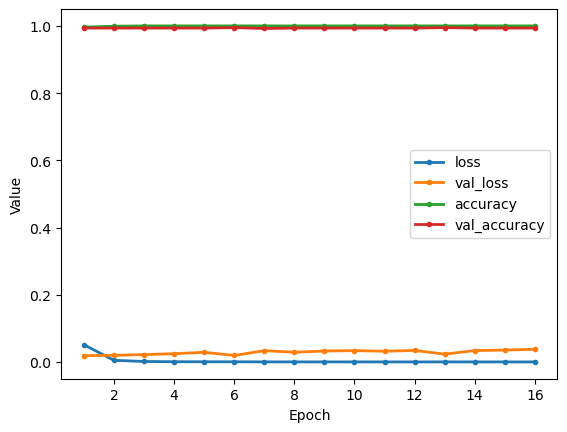

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/31 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step

 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

 6/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

11/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

16/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

21/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

26/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [26]:
report.save()

Report saved as Output/Reports/NF-YA/report_YKBJSU22.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################